### IMPORTANT :  Avant de lancer ce notebook il faut importer dans google colab les images Images1.png et Images2.png du dossier Harris (Fichiers -> importer images1 et 2) ###


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
from skimage.io import imread
from skimage.io import imsave
import pickle
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve,cg


In [0]:

def pause():
    plt.draw() 
    plt.pause(0.001)
    input("Press Enter to continue...")
    
def smoothGaussian(im,sigma):
    N=4*sigma
    x=np.arange(-N,N+1).astype(float).reshape(-1,1)
    weights=np.exp(-(x**2)/(2*sigma**2))
    weights=weights/np.sum(weights)  
    im2=scipy.ndimage.convolve(im.astype(float), weights)
    im_smooth=scipy.ndimage.convolve(im2.astype(float), weights.transpose())  
    return im_smooth

def gradient(im_smooth):
    gradient_x=scipy.ndimage.convolve(im_smooth.astype(float),0.5*np.array([[ 1,0,-1]]))
    gradient_y=scipy.ndimage.convolve(im_smooth.astype(float),0.5*np.array([[ 1,0,-1]]).transpose())
    return gradient_x,gradient_y

In [0]:

def smoothedGradient(im,sigma):
    """this function computes a smooth version of the image image using the convolution by a gaussian with standard deviation sigma 
    and then compue the gradient in the x and y direction using kernels [1,0,-1] ans its transpose"""
    #TODO: Code this function (you can use the functions above ) 
    Im_loc_smooth = smoothGaussian(im,sigma)
    im_x,im_y = gradient(Im_loc_smooth)
    
    return im_x,im_y

def HarrisScore(im,sigma1,sigma2,k=0.06):
    Ix,Iy = smoothedGradient(im,sigma1)
    Ixx = Ix*Ix
    Ixy = Ix * Iy
    Iyy = Iy *Iy
    print(im.shape[0])
    N=6*sigma2
    x=np.arange(-N,N+1).astype(float).reshape(-1,1)
    weights=np.exp(-(x**2)/(2*sigma2**2))

    weights=weights/np.sum(weights)
    ##R = np.zeros((im.shape[0],im.shape[1]))
    m11=scipy.ndimage.convolve(Ixx.astype(float),weights)
    m11 = scipy.ndimage.convolve(m11.astype(float),weights.transpose())
    m12=scipy.ndimage.convolve(Ixy.astype(float),weights)
    m12 = scipy.ndimage.convolve(m12.astype(float), weights.transpose())
    m22 = scipy.ndimage.convolve(Iyy.astype(float), weights)
    m22 = scipy.ndimage.convolve(m22.astype(float),weights.transpose())
    R = m11*m22 - m12*m12 - k*(m11 + m22)*(m11 + m22)
    """this function compute the harris score for each pixel in the image and return the result as an image"""
    #TODO implement this function 
   
    return R

def HarrisCorners(im,sigma1,sigma2,k=0.06):
    """this function extract local maximums ion the harris score image that are above 0.005 times the maxium of R and a local miximum in a region a radius 2"""
    R= HarrisScore(im,sigma1=sigma1,sigma2=sigma2,k=0.06)
    import skimage.feature
    #TODO : implement this function by calling skimage.feature.peak.peak_local_max
    peaks = skimage.feature.peak.peak_local_max(R,min_distance=2,threshold_abs = 0.005*np.max(R));
    return peaks
   

def extractPatches(im ,points,N):    
    """this function extracts patches of size N by N centered around each point privded in the matrix points
    and return a nb_points by N by N 3D array """
    assert(N%2==1)
    radius=(N-1)/2
    patches = np.zeros((points.shape[0],N,N))
    for i,p in enumerate (points):

        if p[0]-radius>=0 and p[0]+radius<im.shape[0] and p[1]-radius>=0 and p[1]+radius<im.shape[1]:
            patches[i,:,:]=im[int(p[0]-radius):int(p[0]+radius+1) ,int(p[1]-radius):int(p[1]+radius+1)]
            
    assert(patches.shape[1]==N)
    assert(patches.shape[2]==N)
    return patches
            


def SSDTable(patches1,patches2):
    """this function computes the sum of square differences between each pair of patches"""
    #TODO implement this function
    print(patches1.shape)
    D = np.zeros((patches1.shape[0],patches2.shape[0]))
    for i in range(patches1.shape[0]):
        for j in range(patches2.shape[0]):
            #print(patches1[i,:,:])
            D[i][j] = np.sum(np.power(patches1[i,:,:]-patches2[j,:,:],2))


    table = D;
    return table


def ZMSSDTable(patches1,patches2):
    """this function computes the zero means sum of square differences between each pair of patches"""
    #TODO implement this function
    print(patches1.shape)
    D = np.zeros((patches1.shape[0],patches2.shape[0]))
    for i in range(patches1.shape[0]):
        for j in range(patches2.shape[0]):
            #print(patches1[i,:,:])
            D[i][j] = np.sum(np.power((patches1[i,:,:]-np.mean(patches1[i,:,:]))-(patches2[j,:,:]-np.mean(patches2[j,:,:])),2))
    table = D;
    return table

def NCCTable(patches1, patches2):
    """this function computes the sum of square differences between each pair of patches"""
    # TODO implement this function
    copyP1 = patches1.copy()
    copyP2 = patches2.copy()
    D = np.zeros((patches1.shape[0], patches2.shape[0]))

    copyP1 = [patch-np.mean(patch) for patch in copyP1]
    copyP1 = [(patch/np.linalg.norm(patch) if np.linalg.norm(patch)!=0 else patch) for patch in copyP1]
    copyP1 = np.asarray(copyP1)

    copyP2 = [patch-np.mean(patch) for patch in copyP2]
    copyP2 = [(patch/np.linalg.norm(patch) if np.linalg.norm(patch)!=0 else patch) for patch in copyP2]
    copyP2 = np.asarray(copyP2)

    for i in range(patches1.shape[0]):
        for j in range(patches2.shape[0]):
            D[i,j] = 1-np.sum(np.dot(copyP1[i, :, :],copyP2[j, :, :]))

    table = D;
    return table

# t1=np.arange(0,4*5*5).reshape(4,5,5)
# t2=t1-5

#print(SSDTable(t1,t2))
#array([[    625.,   10000.,   50625.,  122500.],
        #[  22500.,     625.,   10000.,   50625.],
        #[  75625.,   22500.,     625.,   10000.],
        #[ 160000.,   75625.,   22500.,     625.]])   
# t1=patches1[[1,20,50,60],:,:]
# t2=patches2[[1,20,50,60],:,:]
# print(NCCTable(t1, t2))

### Display function:

In [0]:
def displayPeaks(im,peaks,ax ,title="Peaks"):
    # plt.figure()
    # ax=plt.subplot(1,1,1)
    plt.imshow(im,cmap=plt.cm.Greys_r)
    plt.title(title)
    plt.plot(peaks[:,1],peaks[:,0],'.')
    plt.axis((0,im.shape[1],im.shape[0],0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.subplots_adjust(left=0.01, right=0.99, top=1, bottom=0)    
    #plt.show()   


def  displayPatch(im,corners,patches):
    plt.figure()
    ax=plt.subplot(1,1,1)
    plt.imshow(im,cmap=plt.cm.Greys_r) 
    plt.axis((0,im.shape[1],im.shape[0],0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.subplots_adjust(left=0.01, right=0.99, top=1, bottom=0)      
    plt.plot(corners[:,1],corners[:,0],'.')  
    p=np.fliplr(plt.ginput(1))    
    i=np.argmin(np.sum((p-corners)**2,axis=1))
    plt.figure()
    plt.subplot(1,1,1)
    plt.imshow(patches[i,:,:],cmap=plt.cm.Greys_r)


        


def displayMatches(im1,im2,p1,p2):       
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(im1,cmap=plt.cm.Greys_r)     
    for i in range(p1.shape[0]):
        plt.plot([p1[i,1],p2[i,1]],[p1[i,0],p2[i,0]])   
    plt.plot(p1[:,1],p1[:,0],'.')  
    plt.subplot(1,2,2)
    plt.imshow(im2,cmap=plt.cm.Greys_r)
    for i in range(p1.shape[0]):
        plt.plot([p1[i,1],p2[i,1]],[p1[i,0],p2[i,0]])   
    plt.plot(p2[:,1],p2[:,0],'.')   
    #plt.show()
    
def displayMatches2(im1,im2,p1,p2):       
    plt.figure(figsize=(10,10))
    plt.title("Matches im1&im2")
    ax=plt.subplot(1,1,1)
    plt.imshow(np.row_stack((im1,im2)),cmap=plt.cm.Greys_r)     
    for i in range(p1.shape[0]):
        plt.plot([p1[i,1],p2[i,1]],[p1[i,0],p2[i,0]+im1.shape[0]])   
    plt.plot(p1[:,1],p1[:,0],'.')      
    plt.plot(p2[:,1],p2[:,0]+im1.shape[0],'.') 
    plt.axis((0,im1.shape[1],im1.shape[0]+im2.shape[0],0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.subplots_adjust(left=0.01, right=0.99, top=1, bottom=0)
    #plt.show()  

def displayMatches3(im1,im2,p1,p2):       
    plt.figure(figsize=(10,10))
    plt.title("Matches im1&im2")
    ax=plt.subplot(1,1,1)
    plt.imshow(np.column_stack((im1,im2)),cmap=plt.cm.Greys_r)     
    for i in range(p1.shape[0]):
        plt.plot([p1[i,1],p2[i,1]+im1.shape[1]],[p1[i,0],p2[i,0]])   
    plt.plot(p1[:,1],p1[:,0],'.')      
    plt.plot(p2[:,1]+im1.shape[1],p2[:,0],'.') 
    plt.axis((0,im1.shape[1]+im2.shape[1],im1.shape[0],0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.subplots_adjust(left=1, right=2, top=1, bottom=0)
    #plt.show()  
        
    
def extractMatches(table,threshold=0.7):
    bestscore=np.min(table,axis=1)
    bestmatch1=np.argmin(table,axis=1)
    bestmatch2=np.argmin(table,axis=0)
    t=bestmatch2[bestmatch1]
    valid1=t==np.arange(0,t.size) 
    
    table_copy=table.copy()
    table_copy[np.arange(0,table.shape[0]),bestmatch1]=np.max(table)
    bestscore2=np.min(table_copy,axis=1)
    valid2=bestscore<0.9*bestscore2      
       
    valid=valid1&valid2    
    return np.nonzero(valid)[0], bestmatch1[valid]

Main:

600


Text(0.5, 1.0, 'R score')

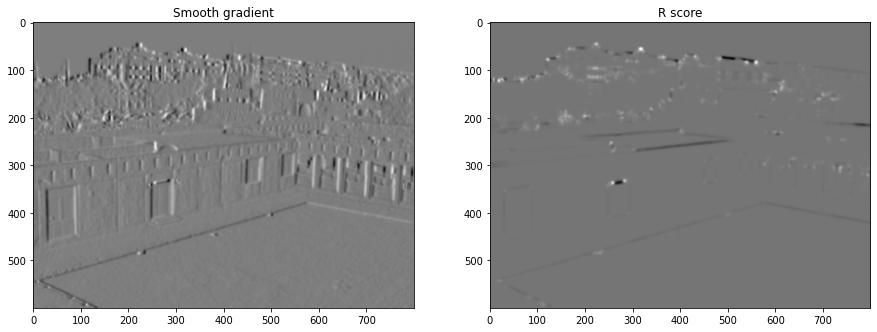

In [95]:


#def main():
plt.ion()
im1col=np.array(imread('Image1.png'))
im2col=np.array(imread('Image2.png'))
# im1col=np.array(imread('set1-1.png'))
# im2col=np.array(imread('set1-2.png'))
im1=np.mean(im1col.astype(np.float),axis=2)
im2=np.mean(im2col.astype(np.float),axis=2)



im_x,im_y=smoothedGradient(im1,sigma=2)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im_x,cmap='gray')
plt.title("Smooth gradient")
#pause()
#im_x[200:205,300:302]
#array([[-0.73459394, -3.24114919],
        #[-0.09954611, -1.66888352],
        #[ 0.18028972, -0.33038019],
        #[ 0.34290241,  0.77111416],
        #[ 0.69410558,  1.81250375]])   
        
#im_y[200:205,300:302]
#array([[-5.57636412, -4.37612   ],
        #[-6.52248546, -5.5795648 ],
        #[-7.72358858, -7.04014021],
        #[-7.84553211, -7.21222404],
        #[-6.19201956, -5.42149942]])    
        
R=HarrisScore(im1,sigma1=2,sigma2=3,k=0.06)
#R[200:205,300:302]
#array([[ 241.9235239 ,  261.08986283],
        #[ 201.38571146,  225.27802866],
        #[ 178.14703746,  208.63364944],
        #[ 173.60252361,  211.83960978],
        #[ 184.0906068 ,  231.22448418]])  
plt.subplot(1,2,2)
plt.title("R function")
plt.imshow(R,cmap=plt.cm.Greys_r)
plt.title('R score')
#pause()
#imsave('harris_response.png',(R-R.min())/(np.max(R)-np.min(R)))


600
600
nb Corner img1=  (392, 2)
nb Corner img2=  (374, 2)


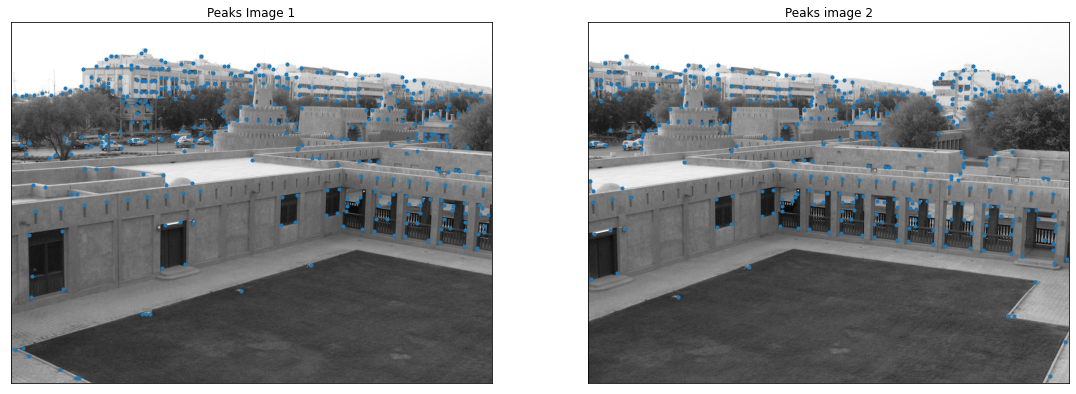

In [96]:

  
corners1=HarrisCorners(im1,sigma1=2,sigma2=3,k=0.06)
#corners1[:10,:]
#array([[ 46, 223],
       #[ 51, 216],
        #[ 56, 166],
        #[ 56, 175],
        #[ 56, 316],
        #[ 61, 159],
        #[ 63, 250],
        #[ 65, 256],
        #[ 67, 303],
        #[ 69, 283]])  
plt.figure(figsize=(15,15))
ax1=plt.subplot(1,2,1)  
displayPeaks(im1,corners1,ax1,"Peaks Image 1")

#pause()


corners2=HarrisCorners(im2,sigma1=2,sigma2=3,k=0.06)
#corners2[:10,:]
#array([[ 56,  64],
        #[ 67,  51],
        #[ 68,  28],
        #[ 70, 216],
        #[ 71, 166],
        #[ 73, 186],
        #[ 73, 641],
        #[ 74, 107],
        #[ 74, 115],
        #[ 77, 240]])  

ax2=plt.subplot(1,2,2)    
displayPeaks(im2,corners2,ax2,"Peaks image 2")

#pause()

print("nb Corner img1= ", corners1.shape)
print("nb Corner img2= ", corners2.shape)

(392, 31, 31)
(374, 31, 31)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


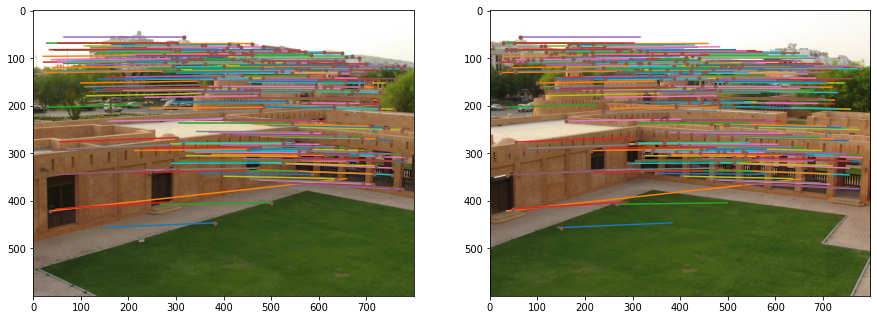

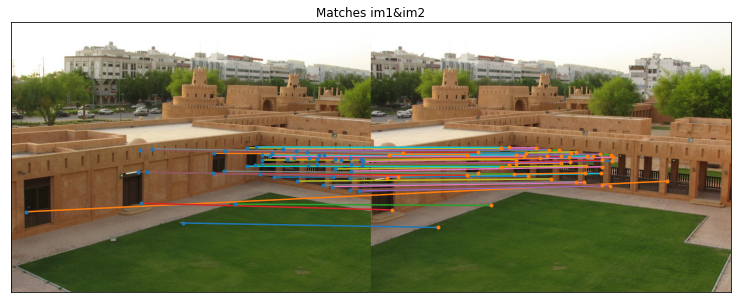

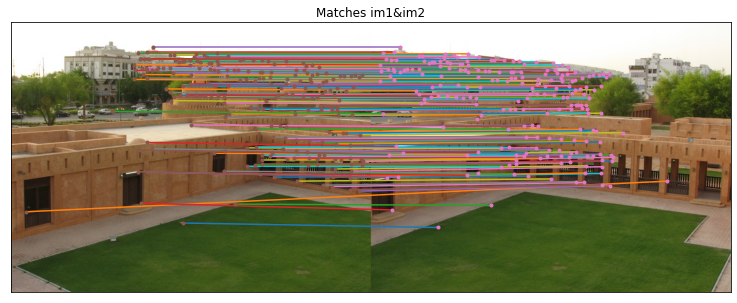

In [97]:

N=31

#print(corners1)
patches1=extractPatches(im1,corners1,N)    
#displayPatch(im1,corners1,patches1)

extractPatches(im1,np.array([[150,300],[200,270]]),3) 
#array([[[ 37.66666667,  41.66666667,  44.33333333],
        #[ 36.33333333,  38.66666667,  40.66666667],
        #[ 37.33333333,  38.        ,  38.66666667]],

      #[[ 75.66666667,  82.66666667,  79.        ],
        #[ 70.66666667,  73.33333333,  73.        ],
        #[ 91.33333333,  92.33333333,  91.33333333]]])   

patches2=extractPatches(im2,corners2,N)



t1=np.arange(0,4*5*5).reshape(4,5,5)
t2=t1-5    
#print(SSDTable(t1,t2))
#array([[    625.,   10000.,   50625.,  122500.],
        #[  22500.,     625.,   10000.,   50625.],
        #[  75625.,   22500.,     625.,   10000.],
        #[ 160000.,   75625.,   22500.,     625.]])    
#print(NCCTable(t1, t2))

#table=SSDTable(patches1,patches2)

table = ZMSSDTable(patches1,patches2)
table2 = ZMSSDTable(patches2,patches1)
#table = NCCTable(patches1, patches2)
matches1,matches2=extractMatches(table,threshold=0.7)
matches3,matches4=extractMatches(table2,threshold=0.7)

p1=corners1[matches1,:]
p2=corners2[matches2,:]

p3=corners2[matches3,:]
p4=corners1[matches4,:]

p1bis = []
p2bis = []
for i in range(0,p1.shape[0]):
    for j in range(0,p3.shape[0]):
        if p1[i,0] == p4[j,0] and p1[i,1] == p4[j,1] and p2[i,0] == p3[j,0] and p2[i,0] == p3[j,0] :
                p1bis.append(p1[i])
                p2bis.append(p2[i])

p1 = np.asarray(p1bis)
p2 = np.asarray(p2bis)


displayMatches(im1col,im2col,p1,p2)
plt.ioff()

displayMatches3(im1col,im2col,p1[0:50,:],p2[0:50,:])
displayMatches3(im1col,im2col,p1,p2)

# if __name__ == "__main__":
#     main()
